In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Read and assign our csv weather dataset into `weather`

In [2]:
weather <- read_csv("weather_data.csv")
head(weather) 

Rows: 8784 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Date/Time, Weather
dbl (6): Temp_C, Dew Point Temp_C, Rel Hum_%, Wind Speed_km/h, Visibility_km...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date/Time     Temp_C Dew Point Temp_C Rel Hum_% Wind Speed_km/h Visibility_km
1 1/1/2012 0:00 -1.8   -3.9             86        4               8.0          
2 1/1/2012 1:00 -1.8   -3.7             87        4               8.0          
3 1/1/2012 2:00 -1.8   -3.4             89        7               4.0          
4 1/1/2012 3:00 -1.5   -3.2             88        6               4.0          
5 1/1/2012 4:00 -1.5   -3.3             88        7               4.8          
6 1/1/2012 5:00 -1.4   -3.3             87        9               6.4          
  Press_kPa Weather             
1 101.24    Fog                 
2 101.24    Fog                 
3 101.26    Freezing Drizzle,Fog
4 101.27    Freezing Drizzle,Fog
5 101.23    Fog                 
6 101.27    Fog

(table 1)

# Weather Classification
### DSCI 100 Group Project Proposal
#### Repository: https://github.com/dvidEast/dsci_weather_classification.git

##### Group 24, Section 008
##### Group Members: David Lim, Livlene Tiwana, Haolan Wu, Bella Zhang
<font size="1">
Project Sources:

https://scied.ucar.edu/learning-zone/how-weather-works/weather 

https://education.nationalgeographic.org/resource/precipitation/ 

https://letstalkscience.ca/educational-resources/stem-explained/why-weather-so-hard-predict 
</font>

<img src="https://media.giphy.com/media/l378pB7qXV89jAXHW/giphy.gif"></img>

<font size="1"> image source: https://wow.uscgaux.info/content.php?unit=140-03-26&category=1338405672 </font> 

### A Little About Weather and Our Data:

Weather predictions play a pivotal role in various aspects of people's daily lives, encompassing 
everyday activities such as commuting to work or school, as well as impacting critical sectors like agriculture and tourism. Consequently, the ability to forecast weather (clear, rain, snow) accurately, utilizing key atmospheric indicators such as temperature, humidity and atmospheric pressure, promises significant convenience for our lives. 

**The question we are trying to answer** is to use these atmospheric indicators to predict forecast weather using classification techniques in R.

Our dataset which collected weather data from various sources including meteorological stations, satellites, weather balloons, and weather radars features the target variables in the weather column representing weather categories, encompassing seven **primary** classifications: 

- clear 
- rain 
- snow
- cloudy
- haze
- fog
- drizzle
- multiple combinations of predictors above 
- (check [weather dataset](https://www.kaggle.com/datasets/bhanupratapbiswas/weather-data) for more)

Because there's an overflow (43) of different (and somewhat insignificant) classes, we had to decide which ones to keep, and which to remove, as keeping them all would be near impossible to classify with any degree of accuracy. Continue reading to find out which!

# Choosing Our Target Variables

#### We can first take the counts of our weather classes to see how many data points are labelled for each class.

We do this to observe any potential imbalances in class distribution. This imbalance can have several implications, and understanding these implications is crucial in the context of algorithms like k-nearest neighbors (KNN).

#### We can first take the counts of our weather classes to see how many data points are labelled for each class.

We do this to observe any potential imbalances in class distribution. This imbalance can have several implications, and understanding these implications is crucial in the context of algorithms like k-nearest neighbors (KNN).

In [3]:
# Get counts:

weather_counts <- weather |>
  group_by(Weather) |>
  summarize(count = n()) |>
  arrange(desc(count))

weather_counts

Weather                                 count
1  Mainly Clear                            2106 
2  Mostly Cloudy                           2069 
3  Cloudy                                  1728 
4  Clear                                   1326 
5  Snow                                     390 
⋮  ⋮                                       ⋮    
46 Rain,Snow,Fog                           1    
47 Snow Pellets                            1    
48 Thunderstorms,Heavy Rain Showers        1    
49 Thunderstorms,Moderate Rain Showers,Fog 1    
50 Thunderstorms,Rain,Fog                  1

(table 2)

#### First, we can observe in table 2 that...
- Mainly Clear (2106)
- Mostly Cloudy (2069)
- Cloudy (1728)
- Clear (1326)
- Snow (390)
- Rain (306)
- Rain Showers (188)
- Fog (150)

On average, have significantly more data points than the rest of our classes. Because it will be near impossible to classify these points with our model (and classifying multiple at once is outside the scope of our question), we will remove those from our possible cases. 

Great! Now we have it narrowed down to 8 target variables. Lets see what this looks like when we plot it against temperature and atmospheric pressure (we will explain why we chose these variables after this section.

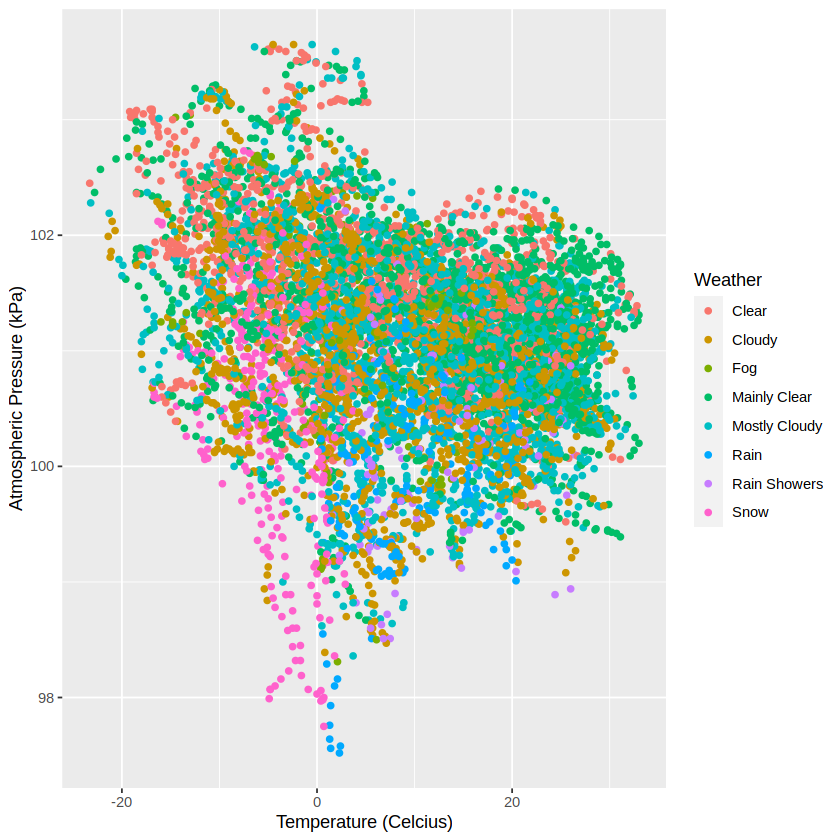

In [4]:
desired_weather <- c("Snow", "Clear", "Rain", "Mostly Clear", "Mainly Clear", "Mostly Cloudy", "Cloudy", "Clear", "Rain Showers", "Fog")

weather_removed_low_count <- weather |>
    filter(Weather %in% desired_weather) |>
    rename(temperature = Temp_C, pressure = Press_kPa, weather = Weather)

weather_data_plot <- weather_removed_low_count |>
    ggplot(aes(x = temperature, y = pressure, color = weather)) +
    geom_point() +
    labs(x = "Temperature (Celcius)", y = "Atmospheric Pressure (kPa)", color = "Weather")

weather_data_plot

(graph 1)

Woah! As you can observe in graph 1, any distinction between classes seems to be masked by overplotted data and lowers our chances of accurately classifying. To combat this, we decided to do some research on how we can distinguish important (real world) variables from the rest.

We found that rain, snow, and clear conditions were often fundamental and easily distinguishable categories, representing distinct atmospheric conditions with significant meanings for various applications. For example, in transportation, rain and snow can impact road safety, while clear weather is generally associated with optimal conditions. Therefore, we select different weather scenarios as the target variable categories. 

Moreover, when observing the distribution of our data, we found that these (rain, snow, and clear) target variable categories are roughly balanced, which improves the accuracy and stability of the prediction model by preventing overfitting one of the variable categories. Observe below...

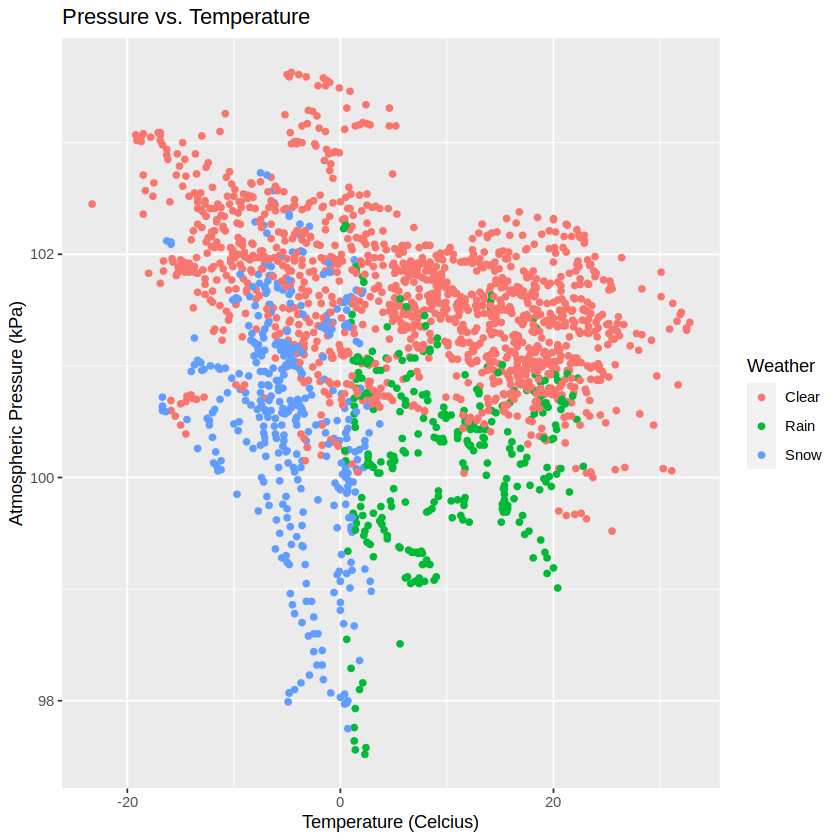

In [5]:
chosen_weather <- c("Snow", "Clear", "Rain")

weather_chosen_variables <- weather |>
    select(Temp_C, Press_kPa, Weather) |>
    filter(Weather %in% chosen_weather) |>
    rename(temperature = Temp_C, pressure = Press_kPa, weather = Weather)

weather_data_plot <- weather_chosen_variables |>
    ggplot(aes(x = temperature, y = pressure, color = weather)) +
    geom_point() +
    labs(x = "Temperature (Celcius)", y = "Atmospheric Pressure (kPa)", title = "Pressure vs. Temperature", color = "Weather")

weather_data_plot

(graph 2)

We can now observe a clear distinction between our three weather classes. We also took into account the possibility of combining the Mainly Clear,
Mostly Cloudy, and Rain Showers classes but found that keeping them helped us balance our target variable categories a little better, and prevented overfitting one of the variable categories. 

So no we can begin our classification! But wait, we should first discuss why we're only looking at temperature and atmospheric pressure, right?

# Choosing Our Predictors

Our [weather dataset](https://www.kaggle.com/datasets/bhanupratapbiswas/weather-data) comprises seven forecasted variables, including temperature, precipitation, humidity, wind speed and direction, atmospheric pressure, cloud cover, and UV index. However, for our project, we will concentrate on two of these variables: 

- Temperature
- Atmospheric pressure

Temperature and atmospheric pressure are reliable indicators for predicting weather conditions as: 

- Clear skies are associated with high atmospheric pressure
- Rain occurs in warmer conditions above freezing temperatures
- Snow is commonly linked to colder temperatures below freezing. The interplay between temperature and atmospheric pressure influences cloud formation and precipitation.

Low atmospheric pressure, coupled with specific temperature levels, leads to the convergence and rising of air, causing condensation and the formation of clouds. The interaction of temperature and pressure ultimately determines the type of precipitation—rain if above freezing or snow if below freezing. 

# Begin Classification

To make predictions for new observations, we will use the k-nearest neighbors classification algorithm and cross-validation to choose our k. The first step in our data analysis is to wrangle our data to the conditions as presented above, namely filtering our weather categories (and renaming them for simplicity). Because we already did this earlier, we'll just reassign that to the variable `weather_wrangled`. We'll also **standardize** our data so our data won't be too heavily skewed towards pressure as well ass `bake` the recipe so we can examine the output.

In [7]:
set.seed(2000)

weather_wrangled <- weather_chosen_variables

weather_recipe <- recipe(weather ~ pressure + temperature, data = weather_wrangled) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

weather_scaled <- weather_recipe |>  
                            prep() |> 
                            bake(weather_wrangled)

slice(weather_scaled, 1:6)

pressure    temperature weather
1 -1.51345396 -0.1130329  Rain   
2 -1.57652603 -0.1746255  Rain   
3 -0.24150070 -1.6792444  Snow   
4  0.58894812 -1.9344137  Clear  
5  0.07385961 -1.6528476  Snow   
6 -0.22047668 -1.4416730  Snow

Next we'll split our data into training and testing sets using 0.75 proportion for our training set based on:
- size: enough data point to allocate a smaller percentage for testing so our model is more accurate) 
- complexity: lowered our complexity of parameters so we don't need as large of testing set to get a more accurate estimate of its generalization performance.

In [8]:
set.seed(2000)

weather_split <- initial_split(weather_wrangled, prop = 0.75, strata = weather)

weather_train <- training(weather_split)

weather_test <- testing(weather_split)

(table 3)

Then we will choose our k-value by preforming a 5-fold cross validation and setting our seed to 2000 for reproducibility.

In [9]:
set.seed(2000)

k_vfold <- vfold_cv(weather_train, v = 5, strata = weather)

Next, we can perform the workflow analysis. We will also use our `weather recipe` that we created above and display our results for each k we try. We decided to set our grid to 30 to make sure that we could observe a large range of k values in case there was a peak somewhere that we could have missed.

In [10]:
set.seed(2000)
install.packages("kknn")

knn_recipe <- weather_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

k_vals <- tibble(neighbors = seq(from = 1, to = 15))

knn_result <- knn_workflow |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics()

knn_result

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



neighbors .metric  .estimator mean      n std_err     .config              
1  1         accuracy multiclass 0.8197078 5 0.015271717 Preprocessor1_Model01
2  1         roc_auc  hand_till  0.8231918 5 0.010210621 Preprocessor1_Model01
3  2         accuracy multiclass 0.8183899 5 0.015350164 Preprocessor1_Model02
4  2         roc_auc  hand_till  0.8867734 5 0.007600723 Preprocessor1_Model02
5  3         accuracy multiclass 0.8428257 5 0.013597527 Preprocessor1_Model03
⋮  ⋮         ⋮        ⋮          ⋮         ⋮ ⋮           ⋮                    
26 13        roc_auc  hand_till  0.9366516 5 0.007024609 Preprocessor1_Model13
27 14        accuracy multiclass 0.8475032 5 0.007206948 Preprocessor1_Model14
28 14        roc_auc  hand_till  0.9365990 5 0.006723305 Preprocessor1_Model14
29 15        accuracy multiclass 0.8415538 5 0.006845786 Preprocessor1_Model15
30 15        roc_auc  hand_till  0.9379466 5 0.006559053 Preprocessor1_Model15

(table 4)

We can now take a look at a graph of k accuracies between 1 and 30 to see which one is most accurate for our model to use. We suspect this value will be relatively high as we have some overlap in "areas" of distinction and need enough k's to dictate an accurate class.

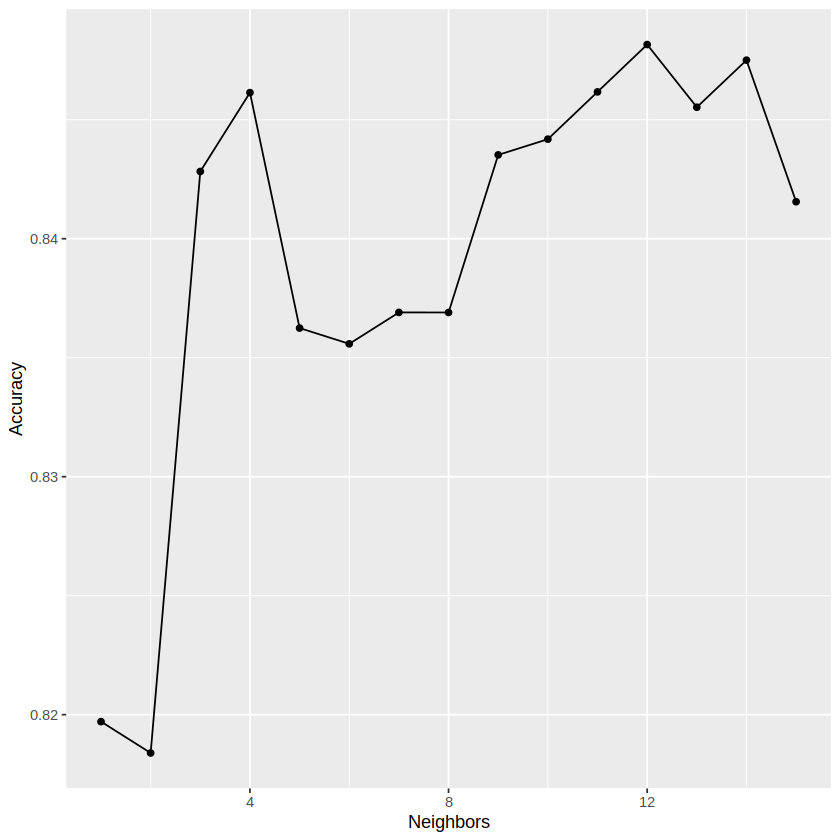

In [11]:
knn_accuracies <- knn_result |>
    filter(.metric == "accuracy")

cross_val_plot <- knn_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy")

cross_val_plot

(graph 3)

We can see in graph 3, that having k = 12 neighbours would give us the highest accuracy where its left and right points do not vary durastically in accuracy. This make intuitive sense as we have some overlapping "sections" of classes in our graph and so utilizing a slightly higher k value would be most beneficial to encompass a wider radius of datapoints.

In [12]:
set.seed(2000)

weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

weather_results <- workflow() |>
    add_recipe(weather_recipe) |>
    add_model(weather_spec) |>
    fit(data = weather_train)

weather_results

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(12,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.149835
Best kernel: rectangular
Best k: 12

# Classifying Our Testing Data
We can now try to predict the class label for our testing set `weather_test` using what we found above.

In [13]:
set.seed(2000)

weather_test_predictions <- predict(weather_results, weather_test)|>
    bind_cols(weather_test) |>
    mutate(weather = as.factor(weather))


weather_test_predictions

.pred_class temperature pressure weather
1   Rain          3.1        99.68   Rain   
2   Snow        -10.2       100.89   Snow   
3   Snow         -9.4       100.79   Snow   
4   Snow         -5.0       100.24   Snow   
5   Snow         -7.1       100.31   Snow   
⋮   ⋮           ⋮           ⋮        ⋮      
503 Snow        -6.1        101.27   Clear  
504 Snow        -5.8        100.78   Snow   
505 Snow        -4.6        100.63   Snow   
506 Clear       -1.3        100.19   Snow   
507 Snow         0.2        100.03   Snow

(table 5)

And finally, lets look at how accurate we are classifying our testing data. I will first turn my columns into numeric, so truth is not a character.

In [14]:
set.seed(2000)

weather_prediction_accuracy <- weather_test_predictions |>
        metrics(truth = weather, estimate = .pred_class)             

weather_prediction_accuracy

.metric  .estimator .estimate
1 accuracy multiclass 0.8382643
2 kap      multiclass 0.6654193

## Discussion

#### Summary of Our Findings
We found a strong correlation between our predictors and target variables through an analysis that aligned with our expectations, demonstrating high accuracy in classifying rain, snow, and clear weather based on atmospheric pressure and temperature variables.


#### Expectations vs. Reality
The interplay of these factors influences weather changes. While a model using atmospheric pressure and temperature aids in predicting future weather conditions, we did expect that the overlapping data points in visualizations suggest the complexity of weather influenced by various factors like wind, humidity, and precipitation. This would be a clear indication as to why our accuracy was a bit aways from perfect, but it still displays a strong correlation between our chosen factors.

#### Impacts of Our Findings
The recognition of the Earth's atmosphere as a complex and chaotic system underscores the challenges in achieving long-term weather prediction accuracy, given its sensitivity to initial conditions. Despite these challenges, our study highlights the crucial role of weather prediction in ensuring safety, supporting economic activities, and informing decision-making processes. This emphasizes the ongoing need for advancements in forecasting models to mitigate uncertainties and enhance the reliability of weather predictions. The implications extend beyond scientific understanding, impacting daily life, various industries, and societal resilience.

#### Ongoing Questions
The study prompts exploration of additional predictors for improved accuracy, raising questions about the impact of diverse geographical data on results and suggesting avenues for future research to enhance forecasting models.